In [2]:
import sys
import os
import chardet
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import xgboost as xgb
import multiprocessing
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import preprocessing

from pandas.api.types import is_numeric_dtype
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold, chi2, f_regression, r_regression, RFECV, RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model, tree, ensemble
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import plot_tree

### **Functions**

In [4]:
DEFAULT_COLUMNS_TO_DROP = ["Unnamed: 0", "org_name", "wealth_screen_data", "attributes", "deceased", "key_indicator"]
subdirectory_name = "pred_mod_products"
today = datetime.today()

In [5]:
def setup_output_directory(save_all_products, save_figures):
    """
    Creates a subdirectory if it does not already exist.
    Note:
        This function relies on the global variable `subdirectory_name`.
    """

    if save_figures or save_all_products:
        subdirectory = subdirectory_name
        if not os.path.exists(subdirectory):
            os.makedirs(subdirectory)
            print(f"Subdirectory '{subdirectory}' created.")
        else:
            print(f"Subdirectory '{subdirectory}' already exists.")

    return None

In [6]:
def melt_ntop(df, ntop=5, column = "first_gift_fund"):

    # make everything lower case
    if not is_numeric_dtype(df[column]):
        df[column] = df[column].str.lower()
    
    # Filter out rows with NA values in column
    threshold = len(df) * 0.05

    df_ntop = df.dropna(subset=[column]) \
        .groupby(column) \
        .filter(lambda x: len(x) > threshold) \
        .groupby(column) \
        .size() \
        .sort_values(ascending=False) \
        .reset_index(name='count')
    
    # Get the top 5 funds
    top_vars = df_ntop[column].tolist()   
    
    # Create new columns for each of the top 5 funds
    for var in top_vars:
        var_str = str(var).replace(".", "_").replace('@', '_').replace(' ', '_')
        var_column_name = "%s_%s_binary" %(column, var_str)
        var_column_name = var_column_name.replace('__', '_')
        #print(var, var_str, var_column_name)
        df[var_column_name] = df[column].apply(lambda x: 1 if x == var else 0)

    df = df.drop(columns=[column])

    return(df)

def calculate_age(birth_date):
    if isinstance(birth_date, str):
        birth_date = datetime.strptime(birth_date, '%Y-%m-%d')
        today = datetime.now()
        age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
        fraction = (today - birth_date.replace(year=today.year)).days / 365.25
        age_decimal = age + fraction
        return age_decimal
    else:
        return np.nan

import numpy as np

def bin_and_convert_to_binary(ages):

    # Define bin edges
    bin_edges = [0, 30, 40, 50]

    # Bin the ages into groups
    binned_ages = np.digitize(ages, bins=bin_edges)
    
    # Convert binned ages into binary representation
    binary_ages = np.eye(len(bin_edges) + 1)[binned_ages]
    
    return binary_ages

In [7]:
### Read the File
def pred_mod_read_file(client_name="national_scleroderma_foundation", df_cd=None, verbose=0):
    if df_cd is None:
        if verbose==1:
            print("Reading the constituent file")
            
        path = "/home/RMittal@ccsfundraising.com/ccs_pred_mod"
        filename =  "%s_constituent_ccsdb.csv" %(client_name)
        myfile = "%s/%s" %(path, filename)
        df_cd = pd.read_csv(myfile, encoding="ISO-8859-1")
        if (verbose==1):
            print("Number of lines read:", len(df_cd))
    else:
        print("Data being read from dataframe: %d lines read" %(len(df_cd)))
    
    df_cd = df_cd.dropna(how="all", axis=1)
    return(df_cd)

In [7]:
DEFAULT_COLUMNS_TO_DROP = ["Unnamed: 0", "org_name", "wealth_screen_data", "attributes"]

def pred_mod_feature_transformation(df_cd, columns_to_drop=DEFAULT_COLUMNS_TO_DROP, verbose=0):

    if verbose==1:
            print("Feature Transformation")

    ### Drop Unwanted Columns
    #########################
    columns_to_drop=["Unnamed: 0", "org_name", "wealth_screen_data", "attributes"]

    # Filter the list to include only existing columns
    existing_columns_to_drop = [col for col in columns_to_drop if col in df_cd.columns]

    for col in existing_columns_to_drop:
        if col in df_cd.keys().to_list():
            df_cd = df_cd.drop(columns=col)

    ### has_spouse_binary
    #####################
    columns_spouse = [key for key in df_cd.columns if "spouse" in key.lower() and "deceased" not in key.lower()]
    df_cd["has_spouse_binary"] =  df_cd[columns_spouse].notna().any(axis=1).astype(int)
    df_cd = df_cd.drop(columns=columns_spouse)

    ### Convert Date of Birth to Age in Decimal
    ###########################################
    columns_age = ["age"]
    for col in columns_age:
        df_cd[col] = pd.to_datetime(df_cd[col])
        dob_array = df_cd[col]
        ages_decimal = np.array(["%2.2f" %((today - dob).days/365.25) for dob in dob_array]).astype(float)
        ages_decimal[ages_decimal < 0] = np.nan
    #    ages_decimal = [calculate_age(date) for date in dob]
        df_cd = df_cd.drop(columns=[col])
        df_cd[col] = ages_decimal

    ### Age Binning
    ###############
    col = "age"
    bin_edges = [0, 30, 40, 50, 200]
    A = pd.cut(df_cd[col], bins=bin_edges, labels=False, right=False)

    # Convert binned ages into binary representation
    binary_ages = pd.get_dummies(A, prefix=col)

    # Join the binary columns to the original DataFrame
    df_cd = pd.concat([df_cd, binary_ages], axis=1)

    # Rename the binary columns
    binary_column_names = ["%s_%s_binary" %(col, edge) for edge in bin_edges[1:]]
    column_mapping = {binary_ages.keys().to_list()[i]:binary_column_names[i] for i in range(len(binary_ages.keys()))}
    df_cd.rename(columns=column_mapping, inplace=True)

    ### Dates to Days
    #################
    column_dates = [key for key in df_cd.columns if "date" in key.lower()] 
    if "class_year" in df_cd.columns:
        column_dates = column_dates + ["class_year"]
        
    for col in column_dates:
        df_cd[col] = pd.to_datetime(df_cd[col])
        col_days = (today - df_cd[col]).dt.days
        col_days[col_days < 0] = np.nan
        df_cd = df_cd.drop(columns=col)
        df_cd[col] = col_days

    ### Prefix for Dr/Prof
    ######################
    df_cd["prefix"] = df_cd["prefix"].astype(str)
    df_cd["prefix_has_dr_binary"] = df_cd["prefix"].str.contains(r"(dr|prof)", case=False).astype(int)
    df_cd = df_cd.drop(columns=["prefix"])

    ### Address
    ###########
    df_cd["incomplete_address_binary"] = ((df_cd['address_1'].isna()) | (df_cd['home_city'].isna()) | \
                               (df_cd['home_state'].isna()) | (df_cd['zip'].astype(str).str.len() < 5)).astype(int)

    ### Check for Presence/Absence
    ##############################
    columns_binaries = ["middle_name", "address_2", "head_of_household", "number_of_children", \
                        "history_of_volunteer", "employer_name", "business_address", \
                        "seasonal_address", "business_email", \
                        "home_phone", "cell_phone", "business_phone"]

    # Filter the list to include only existing columns
    existing_columns_binaries = [col for col in columns_binaries if col in df_cd.columns]

    # Convert non-null entries into binary columns
    binary_df = pd.get_dummies(df_cd[existing_columns_binaries].notnull().astype(int))
    column_mapping = {key:"%s_binary" %key for key in binary_df.keys()}
    binary_df.rename(columns=column_mapping, inplace=True)

    # Drop the original columns
    df_cd = df_cd.drop(columns=existing_columns_binaries)

    # Concatenate the binary columns with the original DataFrame
    df_cd = pd.concat([df_cd, binary_df], axis=1)

    ### Email Domains
    #################
    #col_emails = [key for key in df_cd.keys() if "email" in key.lower()]
    columns_emails = ["personal_email"]
    existing_columns_emails = [col for col in columns_emails if col in df_cd.columns]
    for col in existing_columns_emails:
    #    print(col)
        df_cd[col] = df_cd[col].astype(str)
        if len(df_cd[df_cd[col].notna()]) & len(df_cd[df_cd[col]!="nan"])>0:
            col_type = df_cd[col].str.split(pat="@", expand=True)[1]
            df_cd = df_cd.drop(columns=col)
            df_cd[col] = col_type
            df_cd = melt_ntop(df=df_cd, ntop=5, column=col)

    ### Top 5 Binaries
    ##################
    columns_melt = ["home_city", "home_state", "suffix", "last_action_type", "marital_status",\
            "constituent_type_1", "constituent_type_2", "number_of_special_events_attended"]
    existing_columns_melt = [col for col in columns_melt if col in df_cd.columns]
    for col in existing_columns_melt:
        #print(col)
        df_cd = melt_ntop(df=df_cd, ntop=5, column=col)

    return(df_cd)

In [8]:
def pred_mod_filters(df_cd, verbose=0):

    if verbose==1:
        print("Applying Filters")

    df_cd = df_cd[(~df_cd["is_deceased"] | df_cd["is_deceased"]==0) & (df_cd["is_individual"] | df_cd["is_individual"]==1)]
    if "home_country" in df_cd.columns:
        df_cd = df_cd[df_cd["home_country"].str.contains("USA|U\.S\.A\.|United States|America", case=False)]

    df_indicators = pd.concat([df_cd.pop(col) for col in ["is_deceased", "is_individual"]], axis=1)

    return(df_cd)

def pred_mod_taggers(df_cd, verbose=0):

    if verbose==1:
        print("Extracting Taggers")

    columns_taggers = ["first_name", "last_name", "home_country", "address_1", "zip",\
                    "current_trustee", "past_trustee", "assigned_manager", \
                    "lifetime_hard_credits", "lifetime_soft_credits", "five_year_giving", \
                    "first_gift_amount", "most_recent_gift_amount", "number_of_gifts"]
    existing_columns_taggers = [col for col in columns_taggers if col in df_cd.columns]
                    
    df_taggers = pd.concat([df_cd.pop(col) for col in existing_columns_taggers], axis=1)
    df_taggers["constituent_id"] = df_cd["constituent_id"]

    return(df_cd, df_taggers)


def pred_mod_sklearn_preprocessing(df_cd, verbose=0):

    if verbose==1:
        print("Sklearn: Preprocessing of Numeric and Categorical Features")

    ### Drop all columns that are NaN
    df_reg = df_cd.dropna(how="all", axis=1)

    ### Drop all columns where 80% of the entires are NaN
    df_reg = df_reg.dropna(axis=1, thresh=len(df_reg)*0.05)

    ### Convert the lifetime giving into log1p
    df_reg["lifetime_giving"] = np.log1p(df_reg["lifetime_giving"])/np.log(10)

    columns_binary = [key for key in df_reg.keys() if "binary" in key.lower()]
    if len(columns_binary)>0:
        df_reg_subset = pd.concat([df_reg.pop(col) for col in columns_binary], axis=1)
    else:
        df_reg_subset = pd.DataFrame()
    df_reg_subset["m_giving_logp1"] = df_reg.pop("lifetime_giving")
    df_reg_subset["constituent_id"] = df_reg.pop("constituent_id")

    X = df_reg

    ### Preprocessing the predictors (scaling numeric variables and encoding categorical variables, feature_selection etc)
    numeric_features = [col for col in X.columns if is_numeric_dtype(X[col])]
    categorical_features = [col for col in X.columns if not is_numeric_dtype(X[col])]

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehotencoder', OneHotEncoder(min_frequency=0.05))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    ### Reset indices of X_preprocessed and df_reg_subset
    df_reg_subset = df_reg_subset.reset_index(drop=True)

    df_preprocessed = pd.concat([pd.DataFrame(data=X_preprocessed, columns=X.columns), \
                                df_reg_subset], axis=1)
    df_preprocessed = df_preprocessed.dropna(how="any")
    m_giving_logp1 = df_preprocessed.pop('m_giving_logp1')
    constituent_id = df_preprocessed.pop('constituent_id')

    print(len(df_preprocessed), len(m_giving_logp1), len(constituent_id))
    return(df_preprocessed, m_giving_logp1, constituent_id)

In [9]:
def pred_mod_feature_selection(df_preprocessed, m_giving_logp1, verbose=0):

    if verbose==1:
        print("Sklearn: Feature Selection")

    pred_mod_features = {}

    ### y
    y = m_giving_logp1
    ### All columns
    xcol_all = df_preprocessed.keys().tolist()
    pred_mod_features["all"] = xcol_all

    ### Variance Threshold
    X = df_preprocessed[xcol_all]
    for threshold in [0.01, 0.05, 0.1]:
        selector = VarianceThreshold(threshold=threshold)
        X_reduced = selector.fit_transform(X, y)

        cols = selector.get_support(indices=True)
        ncols = len(cols)
        pred_mod_features["var_%d" %(threshold*100)] = X.iloc[:,cols].columns.tolist()

    ### F_Statistic Threshold
    q = 0.01
    dfn = 1
    dfd = len(X) - 2
    f01 = sp.stats.f.isf(q, dfn, dfd)

    # %%
    X = df_preprocessed[xcol_all]
    f_stat, p_values = f_regression(X, y)
    cols_f_stat = list(np.where(f_stat>f01)[0])
    xcol_f_stat = X.iloc[:,cols_f_stat].columns.tolist()
    pred_mod_features["f_stat"] = xcol_f_stat 

    ### Pearson_R Threshold
    X = df_preprocessed[xcol_all]
    r_pearson = np.abs(r_regression(X, y))
    cols = list(np.where(r_pearson>=np.mean(r_pearson))[0])
    ncols = len(cols)
    xcol_rpearson_mean = X.iloc[:,cols].columns.tolist()
    pred_mod_features["r_pearson"]= xcol_rpearson_mean

    ### Recursive Feature Elimination
    #################################

    if verbose==1:
        print("Recursive Feature Elimination")

    est_dict = {"lm": linear_model.LinearRegression(), "xgb": xgb.XGBRegressor(booster="gbtree"), \
                "xgbrf": xgb.XGBRFRegressor(), "svr": SVR(kernel="linear"), \
                "rf": RandomForestRegressor(n_estimators=100, oob_score=True, bootstrap=True, random_state=42)
            }

    run = True 
    if run:
        for est in ["xgb"]:#, "lm"]:
            if verbose==2:
                print("Recursive Feature Elimination:", est)
            estimator = est_dict[est]
            X = df_preprocessed[xcol_all]
            y = m_giving_logp1
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
            rfe = RFECV(estimator=estimator, step=1, min_features_to_select=1, verbose=0, \
                        n_jobs=(multiprocessing.cpu_count()//2), cv=3,\
                        scoring="neg_mean_squared_error")
            #print("Fitting %s" %est)
            rfe.fit(X=X_train, y=y_train)
            #print(f"Optimal number of features: {rfe.n_features_}")

            cols = rfe.get_support(indices=True)
            pred_mod_features["rfecv_%s" %est] = X.iloc[:,cols].columns.tolist()

    return(pred_mod_features)

In [10]:
def pred_mod_fitting(df_preprocessed, df_taggers, m_giving_logp1, constituent_id, pred_mod_features, \
                     client_name, save_all_products=True, save_figures=True, verbose=0):
    """
    Fits predictive models to the preprocessed data and returns the final DataFrame with scores.

    Args:
        df_preprocessed (pandas.DataFrame): The preprocessed DataFrame with predictors.
        df_taggers (pandas.DataFrame): The DataFrame containing extracted tagger columns.
        m_giving_logp1 (pandas.Series): The log-transformed target variable.
        constituent_id (pandas.Series): The constituent IDs.
        pred_mod_features (dict): A dictionary containing lists of selected features for each feature selection method.
        client_name (str): The name of the client.
        save_all_products (bool, optional): Whether to save all intermediate products. Default is True.
        save_figures (bool, optional): Whether to save diagnostic plots. Default is True.
        verbose (int, optional): Verbosity level (0, 1, or 2) to control print statements. Default is 0.

    Returns:
        pandas.DataFrame: The final DataFrame with scores.
    """

    if (verbose==1 or verbose==2):
        print("Sklearn: Model Fitting")

    ### Initialize df_final (for experiments, mostly)
    #################################################

    setup_output_directory(save_all_products, save_figures)
    df_final = None  

    ### Model Fitting
    #################

    run = True
    if run:
        folds = 5

        ### X
        # features = {"all": xcol_all, "var_1": xcol_var_1, "var_10": xcol_var_10, "var_5": xcol_var_5, \
        #             "f_stat": xcol_f_stat, "r_pearson": xcol_rpearson_mean,\
        #             "rfecv_xgb": xcol_rfecv_xgb, "rfecv_lm": xcol_rfecv_lm}
        #             # "f_stat_med": xcol_f_stat_med,

        ### List of models to be tested
        algorithms = {"LR": linear_model.LinearRegression(), "GBR": ensemble.GradientBoostingRegressor(), \
                    "XGBR": xgb.XGBRegressor(), "XGBRF": xgb.XGBRFRegressor(),\
                    "DTR": tree.DecisionTreeRegressor()}

        # features = {"rfecv_xgb": xcol_rfecv_xgb, "rfecv_lm": xcol_rfecv_lm}
        # algorithms = {"XGBR": xgb.XGBRegressor(), "LR": linear_model.LinearRegression()}

        model_feature_importance = {}
        model_pred = {}
        model_stats = {}
        model_evaluation = {}

        y = m_giving_logp1
        for feature_type, cols in pred_mod_features.items():

            if verbose==1:
                print("Sklearn: Model Fitting -- ", feature_type)
            
            X = df_preprocessed[cols]
            
            # Creating a training set index by partitioning the dataset
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
            #print("feature_type = %10s | No. of cols = %3d" %(feature_type, len(cols)))
        
            model_feature_importance[feature_type] = {}
            model_pred[feature_type] = {}
            model_stats[feature_type] = {}
            model_evaluation[feature_type] = {}
            
            globals() ["model_df_%s" %(feature_type)] = pd.DataFrame({"Features": X.keys().tolist()})
            for algo_name, model in algorithms.items():

                if verbose==2:
                    print("Sklearn: Model Fitting -- ", feature_type, algo_name)
                
                ### Fitting
                scores = cross_val_score(model, X_train, y_train, cv=folds, scoring='neg_root_mean_squared_error')
                results = model.fit(X_train, y_train)
                y_pred = results.predict(X_test)
            
                ### Statistics
                # Calculate MAE, MSE and RMSE
                mae = mean_absolute_error(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                rmse = mean_squared_error(y_test, y_pred, squared=False)
            
                ### Populate the dictionaries and the dataframe

                try:
                    if hasattr(model, 'feature_importances_'):
                        model_feature_importance[feature_type][algo_name] = results.feature_importances_
                    elif hasattr(model, 'coef_'):
                        model_feature_importance[feature_type][algo_name] = results.coef_.flatten()
                #except AttributeError:
                #    print("%s object has no attribute feature_importances_ or coef_" %algo_name)
                except:
                    pass

                model_pred[feature_type][algo_name] = y_pred
                model_stats[feature_type][algo_name] = [mae, mse, rmse]
                model_evaluation[feature_type][algo_name] = -scores.mean()
                #, X_train.shape, len(cols), model_feature_importance[feature_type][algo_name])
                
                try:
                    globals() ["model_df_%s" %(feature_type)]["Coeff_%s" %algo_name] = model.coef_
                except:
                    pass  
            break

        # Your list of tuples
        data = [(key, len(pred_mod_features[key]), key1, model_stats[key][key1][2]) for key in model_stats.keys() for key1 in model_stats[key].keys()]

        # Create a DataFrame
        df_matrix = pd.DataFrame(data, columns=["Feature_Selection", "N_Features", "Estimator", "Root_Mean_Square_Error"])
        if (save_all_products):
            df_matrix.to_csv("%s/%s_pred_mod_matrix.csv" %(subdirectory_name, client_name), index=True)

    ### Best Fit Model
    ##################
    print("Fitting for the Best-Fit Model")
    best_fit_idx = df_matrix.Root_Mean_Square_Error.idxmin()
    best_fit_algo_name = df_matrix.iloc[best_fit_idx]["Estimator"]
    best_fit_feature_type = df_matrix.iloc[best_fit_idx]["Feature_Selection"]

    model = algorithms[best_fit_algo_name]
    cols = pred_mod_features[best_fit_feature_type]
    X = df_preprocessed[cols]
    y = m_giving_logp1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    results = model.fit(X_train, y_train)
    y_pred_train = results.predict(X_train)
    y_pred_test = results.predict(X_test)
    y_pred_all = results.predict(X)
    y_scores = y_pred_all*(100.0/y_pred_all.max())

    df_preprocessed["constituent_id"] = constituent_id
    df_preprocessed["m_giving_1p"] = y
    df_preprocessed["scores"] = y_scores
    df_final = df_preprocessed[["constituent_id", "m_giving_1p", "scores"]].merge(df_taggers, on=["constituent_id"], how="left")
    if save_all_products:
        df_final.to_csv("%s/%s_pred_mod_scores.csv" %(subdirectory_name, client_name), index=False)

    ### Save Figures
    if save_all_products:
        with open("%s/%s_pred_mod_bestfit_results_%s_%s.pkl" %(subdirectory_name, client_name, best_fit_algo_name, best_fit_feature_type),"wb") as f:
            pickle.dump(results,f)
        with open("%s/%s_pred_mod_bestfit_model_%s_%s.pkl" %(subdirectory_name, client_name, best_fit_algo_name, best_fit_feature_type),"wb") as f:
            pickle.dump(model,f)


    ### Diagnostic Plots for the Best-Fit Model
    ###########################################

    if save_figures:
        print("Diagnostic Plots")

        # Ground Truth vs Predicted
        colors = cm.prism(np.linspace(0, 1, len(model_pred.keys())))
        plt.figure(figsize=(4, 4))
        plt.scatter(y, y_pred_all, color='green', alpha=0.5, s=0.3)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('True vs Predicted Values')
        plt.savefig("%s/%s_pred_mod_scatter_plot.jpg" %(subdirectory_name, client_name), bbox_inches="tight")

        # Residuals
        residuals = y_test - y_pred_test
        plt.figure(figsize=(4, 4))
        plt.hist(residuals, bins=20)
        plt.xlabel('Residual')
        plt.ylabel('Frequency')
        plt.title('Distribution of Residuals')
        plt.savefig("%s/%s_pred_mod_residuals_hist.jpg" %(subdirectory_name, client_name), bbox_inches="tight")

    return df_final

### Main

Sklearn: Model Fitting
Subdirectory 'pred_mod_products' already exists.
Sklearn: Model Fitting --  all
Fitting for the Best-Fit Model
Diagnostic Plots


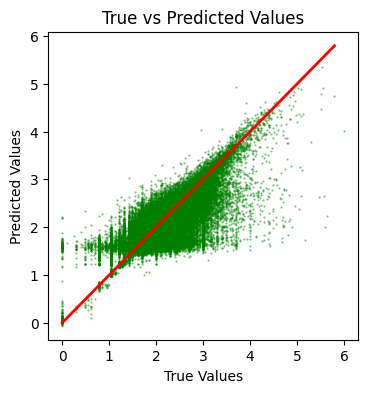

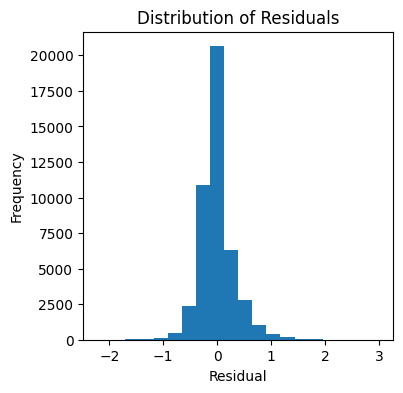

In [49]:
client_name = "national_scleroderma_foundation"
verbose_default = 1
#df_pred_mod_input = pred_mod_read_file(client_name, df_cd=None, verbose=verbose_default)
#df_pred_mod_ft = pred_mod_feature_transformation(df_pred_mod_input, columns_to_drop=DEFAULT_COLUMNS_TO_DROP, \
#                                                 verbose=verbose_default)
# df_pred_mod_filters = pred_mod_filters(df_pred_mod_ft, verbose=verbose_default)
# df_pred_mod_sklearn, df_pred_mod_taggers = pred_mod_taggers(df_pred_mod_filters, verbose=verbose_default)
# df_pred_mod_preprocessed, m_giving_logp1, constituent_id = pred_mod_sklearn_preprocessing(df_pred_mod_sklearn, \
#                                                               verbose=verbose_default)
# pred_mod_features = pred_mod_feature_selection(df_pred_mod_preprocessed, m_giving_logp1, verbose=verbose_default)
# [(key, len(pred_mod_features[key])) for key in pred_mod_features.keys()]
pred_mod_scores = pred_mod_fitting(df_pred_mod_preprocessed, df_pred_mod_taggers, \
                  m_giving_logp1, constituent_id, pred_mod_features, client_name, \
                  save_all_products=True, save_figures=True, verbose=verbose_default)

#df_final = pred_mod_fitting(df_preprocessed, df_taggers, pred_mod_features, \
#                            m_giving_logp1, constituent_id, verbose=0)

### **Constituent File**

In [8]:
client = "national_scleroderma_foundation"
path = "/home/RMittal@ccsfundraising.com/ccs_pred_mod"
filename =  "%s_constituent_ccsdb.csv" %(client)
file = "%s/%s" %(path, filename)
df_cd = pd.read_csv(file, encoding="ISO-8859-1")
df_cd = df_cd.dropna(how="all", axis=1)
df_cd = df_cd.rename(columns={"solicit_codes": "solicit_codes_binary"})
df_cd["solicit_codes_binary"] = df_cd["solicit_codes_binary"].astype("bool")

### **Drop unwanted columns**

In [9]:
columns_to_drop=["Unnamed: 0", "org_name", "wealth_screen_data", "attributes", "deceased", "key_indicator"]

# Filter the list to include only existing columns
existing_columns_to_drop = [col for col in columns_to_drop if col in df_cd.columns]

for col in existing_columns_to_drop:
    if col in df_cd.keys().to_list():
        df_cd = df_cd.drop(columns=col)

### **Spouse**

In [10]:
### has_spouse_binary
columns_spouse = [key for key in df_cd.columns if "spouse" in key.lower() and "deceased" not in key.lower()]
df_cd["has_spouse_binary"] =  df_cd[columns_spouse].notna().any(axis=1).astype(int)
df_cd = df_cd.drop(columns=columns_spouse)

### **Date to Age**

In [11]:
# Convert Date of Birth to Age in Decimal
columns_age = ["age"]
for col in columns_age:
    df_cd[col] = pd.to_datetime(df_cd[col])
    dob_array = df_cd[col]
    ages_decimal = np.array(["%2.2f" %((today - dob).days/365.25) for dob in dob_array]).astype(float)
    ages_decimal[ages_decimal < 0] = np.nan
#    ages_decimal = [calculate_age(date) for date in dob]
    df_cd = df_cd.drop(columns=[col])
    df_cd[col] = ages_decimal

### **Age Binning**

In [12]:
col = "age"
bin_edges = [0, 30, 40, 50, 200]
A = pd.cut(df_cd[col], bins=bin_edges, labels=False, right=False)

# Convert binned ages into binary representation
binary_ages = pd.get_dummies(A, prefix=col)

# Join the binary columns to the original DataFrame
df_cd = pd.concat([df_cd, binary_ages], axis=1)

# Rename the binary columns
binary_column_names = ["%s_%s_binary" %(col, edge) for edge in bin_edges[1:]]
column_mapping = {binary_ages.keys().to_list()[i]:binary_column_names[i] for i in range(len(binary_ages.keys()))}
df_cd.rename(columns=column_mapping, inplace=True)

### **Dates to Days**

In [13]:
column_dates = [key for key in df_cd.columns if "date" in key.lower()] 
if "class_year" in df_cd.columns:
    column_dates = column_dates + ["class_year"]
    
for col in column_dates:
    df_cd[col] = pd.to_datetime(df_cd[col])
    col_days = (today - df_cd[col]).dt.days
    col_days[col_days < 0] = np.nan
    df_cd = df_cd.drop(columns=col)
    df_cd[col] = col_days

In [14]:
#column_dates
#g = plt.hist(df_cd["most_recent_gift_date"])

### **Prefix**

In [15]:
df_cd["prefix"] = df_cd["prefix"].astype(str)
df_cd["prefix_has_dr_binary"] = df_cd["prefix"].str.contains(r"(dr|prof)", case=False).astype(int)
df_cd = df_cd.drop(columns=["prefix"])

### **Incomplete address**

In [16]:
df_cd["incomplete_address_binary"] = ((df_cd['address_1'].isna()) | (df_cd['home_city'].isna()) | \
                               (df_cd['home_state'].isna()) | (df_cd['zip'].astype(str).str.len() < 5)).astype(int)

### **Presence/Absence**

In [17]:
columns_binaries = ["middle_name", "address_2", "head_of_household", "number_of_children", \
                    "history_of_volunteer", "employer_name", "business_address", \
                    "seasonal_address", "business_email", \
                    "home_phone", "cell_phone", "business_phone"]

# Filter the list to include only existing columns
existing_columns_binaries = [col for col in columns_binaries if col in df_cd.columns]

# Convert non-null entries into binary columns
binary_df = pd.get_dummies(df_cd[existing_columns_binaries].notnull().astype(int))
column_mapping = {key:"%s_binary" %key for key in binary_df.keys()}
binary_df.rename(columns=column_mapping, inplace=True)

# Drop the original columns
df_cd = df_cd.drop(columns=existing_columns_binaries)

# Concatenate the binary columns with the original DataFrame
df_cd = pd.concat([df_cd, binary_df], axis=1)

### **Email Domains**

In [18]:
### Any Columns with Email
#col_emails = [key for key in df_cd.keys() if "email" in key.lower()]
columns_emails = ["personal_email"]
existing_columns_emails = [col for col in columns_emails if col in df_cd.columns]
for col in existing_columns_emails:
#    print(col)
    df_cd[col] = df_cd[col].astype(str)
    if len(df_cd[df_cd[col].notna()]) & len(df_cd[df_cd[col]!="nan"])>0:
        col_type = df_cd[col].str.split(pat="@", expand=True)[1]
        df_cd = df_cd.drop(columns=col)
        df_cd[col] = col_type
        df_cd = melt_ntop(df=df_cd, ntop=5, column=col)

### **Top 5 Binaries**

In [19]:
#constit_data["home_state"].value_counts()
columns_melt = ["home_city", "home_state", "suffix", "last_action_type", "marital_status",\
          "constituent_type_1", "constituent_type_2", "number_of_special_events_attended"]
existing_columns_melt = [col for col in columns_melt if col in df_cd.columns]
for col in existing_columns_melt:
    #print(col)
    df_cd = melt_ntop(df=df_cd, ntop=5, column=col)

### **Filters and Indicators**

In [20]:
# df_cd["deceased"].value_counts(), df_cd["is_deceased"].value_counts(), \
#     df_cd[(df_cd["deceased"].str.contains("no", case=False))]["is_deceased"].value_counts(),\
#     df_cd[(df_cd["deceased"].str.contains("yes", case=False))]["is_deceased"].value_counts()

In [21]:
    df_cd = df_cd[(df_cd["is_deceased"]==0) & (df_cd["is_individual"]==1)]
    # if "home_country" in df_cd.columns:
    #     df_cd = df_cd[df_cd["home_country"].str.contains("USA|U\.S\.A\.|United States|America", case=False, na=False)]

    df_indicators = pd.concat([df_cd.pop(col) for col in ["is_deceased", "is_individual"]], axis=1)
    if "key_indicator" in df_cd.columns:
        df_cd = df_cd.drop(columns=["key_indicator"])

### **Taggers**

In [22]:
columns_taggers = ["first_name", "last_name", "home_country", "address_1", "zip",\
                  "current_trustee", "past_trustee", "assigned_manager", \
                  "lifetime_hard_credits", "lifetime_soft_credits", "five_year_giving", \
                  "first_gift_amount", "most_recent_gift_amount", "number_of_gifts"]
existing_columns_taggers = [col for col in columns_taggers if col in df_cd.columns]
                  
df_taggers = pd.concat([df_cd.pop(col) for col in existing_columns_taggers], axis=1)
df_taggers["constituent_id"] = df_cd["constituent_id"]

### **Sklearn -- preprocessing**

In [23]:
### Drop all columns that are NaN
df_reg = df_cd.dropna(how="all", axis=1)

### Drop all columns where 80% of the entires are NaN
df_reg = df_reg.dropna(axis=1, thresh=len(df_reg)*0.05)

### Convert the lifetime giving into log1p
df_reg["lifetime_giving"] = np.log1p(df_reg["lifetime_giving"])/np.log(10)

columns_binary = [key for key in df_reg.keys() if "binary" in key.lower()]
if len(columns_binary)>0:
    df_reg_subset = pd.concat([df_reg.pop(col) for col in columns_binary], axis=1)
else:
    df_reg_subset = pd.DataFrame()
df_reg_subset["m_giving_logp1"] = df_reg.pop("lifetime_giving")
df_reg_subset["constituent_id"] = df_reg.pop("constituent_id")

In [27]:
for col in df_reg.columns:
    if (df_reg[col].nunique() == 1) and (df_reg[col].isna().sum()==0):
        print(col)
#        df_reg_subset[col] = df_reg.pop(col)


In [65]:
# Preprocessing the predictors (scaling numeric variables and encoding categorical variables, feature_selection etc)
#numeric_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
#categorical_features = X.select_dtypes(include=["object", "string", "O"]).columns.tolist()

X = df_reg

numeric_features = [col for col in X.columns if is_numeric_dtype(X[col])]
categorical_features = [col for col in X.columns if not is_numeric_dtype(X[col])]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehotencoder', OneHotEncoder(min_frequency=0.05))
    # You may need to add encoding steps for categorical features here
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_preprocessed = preprocessor.fit_transform(X)
#X_preprocessed = np.hstack((np.array(y)[:, np.newaxis], X_preprocessed))

In [66]:
# Reset indices of X_preprocessed and df_reg_subset
df_reg_subset = df_reg_subset.reset_index(drop=True)

df_preprocessed = pd.concat([pd.DataFrame(data=X_preprocessed, columns=X.columns), \
                             df_reg_subset], axis=1)
df_preprocessed = df_preprocessed.dropna(how="any")
m_giving_logp1 = df_preprocessed.pop('m_giving_logp1')
constituent_id = df_preprocessed.pop('constituent_id')


In [67]:
X.shape, len(df_preprocessed.keys()), len(m_giving_logp1), len(constituent_id)

((219102, 4), 39, 151515, 151515)

## **Feature Selection**

In [68]:
### y
y = m_giving_logp1
### All columns
xcol_all = df_preprocessed.keys().tolist()

#### **Variance Threshold**
Feature selector that removes all low-variance features.

In [69]:
X = df_preprocessed[xcol_all]
for threshold in [0.01, 0.05, 0.1]:
#    threshold = 0.05
    selector = VarianceThreshold(threshold=threshold)
    X_reduced = selector.fit_transform(X, y)

    cols = selector.get_support(indices=True)
    ncols = len(cols)
    globals() ["xcol_var_%d" %(threshold*100)] = X.iloc[:,cols].columns.tolist()
    print(len(globals() ["xcol_var_%d" %(threshold*100)]))

33
28
13


#### **F_Statistic Threshold**
Univariate linear regression tests returning F-statistic and p-values.

In [70]:
q = 0.01
dfn = 1
dfd = len(X) - 2
f01 = sp.stats.f.isf(q, dfn, dfd)

In [71]:
X = df_preprocessed[xcol_all]
f_stat, p_values = f_regression(X, y)
cols_f_stat = list(np.where(f_stat>f01)[0])
xcol_f_stat = X.iloc[:,cols_f_stat].columns.tolist()
# plt.figure(figsize=(4, 2))
# g = plt.hist(f_stat, bins=20, color="red")
len(xcol_f_stat)

32

#### **Pearson_R Threshold**
Univariate linear regression tests returning the Pearson Correlation Coefficient.

In [72]:
X = df_preprocessed[xcol_all]
r_pearson = np.abs(r_regression(X, y))
cols = list(np.where(r_pearson>=np.mean(r_pearson))[0])
ncols = len(cols)
xcol_rpearson_mean = X.iloc[:,cols].columns.tolist()
len(xcol_rpearson_mean)

13

#### **Recursive Feature Elimination**

In [73]:
%%time

est_dict = {"lm": linear_model.LinearRegression(), "xgb": xgb.XGBRegressor(booster="gbtree"), \
            "xgbrf": xgb.XGBRFRegressor(), "svr": SVR(kernel="linear"), \
            "rf": RandomForestRegressor(n_estimators=100, oob_score=True, bootstrap=True, random_state=42)
           }
#            "rf": ensemble.RandomForestRegressor()}

# est = "svr" ### Takes too long!! I had to stop after 15 minutes
# est = "rf" ### Takes too long!! I had to stop after 15 minutes
# est = "lm"
# est = "xgb"

#estimator = est_dict[est]

run = True 
if run:
    for est in ["xgb", "lm"]:
        estimator = est_dict[est]
        X = df_preprocessed[xcol_all]
        y = m_giving_logp1
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
        #rfe = RFE(estimator=estimator, step=1, n_features_to_select=25, verbose=2)
        rfe = RFECV(estimator=estimator, step=1, min_features_to_select=1, verbose=0, \
                    n_jobs=(multiprocessing.cpu_count()//2), cv=3,\
                    scoring="neg_mean_squared_error")
        print("Fitting %s" %est)
        rfe.fit(X=X_train, y=y_train)
        print(f"Optimal number of features: {rfe.n_features_}")

        cols = rfe.get_support(indices=True)
        globals()["xcol_rfecv_%s" %est] = X.iloc[:,cols].columns.tolist()
        print("Estimator:", est, "No_of_features:", len(cols))
#    sum(rfe.ranking_==1)

Fitting xgb
Optimal number of features: 35
Estimator: xgb No_of_features: 35
Fitting lm
Optimal number of features: 39
Estimator: lm No_of_features: 39
CPU times: user 2min 7s, sys: 4.62 s, total: 2min 12s
Wall time: 1min 10s


### Model Fitting

In [ ]:
### Initialize df_final (for experiments, mostly)
#################################################

df_final = None  
df_preprocessed = df_pred_mod_preprocessed
df_taggers = df_pred_mod_taggers
save_all_products = True
save_figures = True
verbose = 1
features = pred_mod_features

### Model Fitting
#################

run = True
if run:
    folds = 5

    ## X
    # features = {"all": xcol_all, "var_1": xcol_var_1, "var_10": xcol_var_10, "var_5": xcol_var_5, \
    #             "f_stat": xcol_f_stat, "r_pearson": xcol_rpearson_mean,\
    #             "rfecv_xgb": xcol_rfecv_xgb, "rfecv_lm": xcol_rfecv_lm}
    #             # "f_stat_med": xcol_f_stat_med,

    ### List of models to be tested
    algorithms = {"LR": linear_model.LinearRegression(), "GBR": ensemble.GradientBoostingRegressor(), \
                "XGBR": xgb.XGBRegressor(), "XGBRF": xgb.XGBRFRegressor(),\
                "DTR": tree.DecisionTreeRegressor()}

    #features = {"rfecv_xgb": xcol_rfecv_xgb, "rfecv_lm": xcol_rfecv_lm}
    #algorithms = {"XGBR": xgb.XGBRegressor(), "LR": linear_model.LinearRegression()}

    model_feature_importance = {}
    model_pred = {}
    model_stats = {}
    model_evaluation = {}

    y = m_giving_logp1
    for feature_type, cols in pred_mod_features.items():

        if verbose==1:
            print("Sklearn: Model Fitting -- ", feature_type)
        
        X = df_preprocessed[cols]
        
        # Creating a training set index by partitioning the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
        #print("feature_type = %10s | No. of cols = %3d" %(feature_type, len(cols)))
    
        model_feature_importance[feature_type] = {}
        model_pred[feature_type] = {}
        model_stats[feature_type] = {}
        model_evaluation[feature_type] = {}
        
        globals() ["model_df_%s" %(feature_type)] = pd.DataFrame({"Features": X.keys().tolist()})
        for algo_name, model in algorithms.items():

            if verbose==2:
                print("Sklearn: Model Fitting -- ", feature_type, algo_name)
            
            ### Fitting
            scores = cross_val_score(model, X_train, y_train, cv=folds, scoring='neg_root_mean_squared_error')
            results = model.fit(X_train, y_train)
            y_pred = results.predict(X_test)
        
            ### Statistics
            # Calculate MAE, MSE and RMSE
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
        
            ### Populate the dictionaries and the dataframe

            try:
                if hasattr(model, 'feature_importances_'):
                    model_feature_importance[feature_type][algo_name] = results.feature_importances_
                elif hasattr(model, 'coef_'):
                    model_feature_importance[feature_type][algo_name] = results.coef_.flatten()
            #except AttributeError:
            #    print("%s object has no attribute feature_importances_ or coef_" %algo_name)
            except:
                pass

            model_pred[feature_type][algo_name] = y_pred
            model_stats[feature_type][algo_name] = [mae, mse, rmse]
            model_evaluation[feature_type][algo_name] = -scores.mean()
            #, X_train.shape, len(cols), model_feature_importance[feature_type][algo_name])
            
            try:
                globals() ["model_df_%s" %(feature_type)]["Coeff_%s" %algo_name] = model.coef_
            except:
                pass  
        break

    # Your list of tuples
    data = [(key, len(pred_mod_features[key]), key1, model_stats[key][key1][2]) for key in model_stats.keys() for key1 in model_stats[key].keys()]

    # Create a DataFrame
    df_matrix = pd.DataFrame(data, columns=["Feature_Selection", "N_Features", "Estimator", "Root_Mean_Square_Error"])
    if (save_all_products):
        df_matrix.to_csv("%s/%s_pred_mod_matrix.csv" %(subdirectory_name, client_name), index=True)

### Best Fit Model
##################
print("Fitting for the Best-Fit Model")
best_fit_idx = df_matrix.Root_Mean_Square_Error.idxmin()
best_fit_algo_name = df_matrix.iloc[best_fit_idx]["Estimator"]
best_fit_feature_type = df_matrix.iloc[best_fit_idx]["Feature_Selection"]

model = algorithms[best_fit_algo_name]
cols = pred_mod_features[best_fit_feature_type]
X = df_preprocessed[cols]
y = m_giving_logp1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
results = model.fit(X_train, y_train)
y_pred_train = results.predict(X_train)
y_pred_test = results.predict(X_test)
y_pred_all = results.predict(X)
y_scores = y_pred_all*(100.0/y_pred_all.max())

df_preprocessed["constituent_id"] = constituent_id
df_preprocessed["m_giving_1p"] = y
df_preprocessed["scores"] = y_scores
df_final = df_preprocessed[["constituent_id", "m_giving_1p", "scores"]].merge(df_taggers, on=["constituent_id"], how="left")
if save_all_products:
    df_final.to_csv("%s/%s_pred_mod_scores.csv" %(subdirectory_name, client_name), index=False)

### Save Figures
if save_all_products:
    with open("%s/%s_pred_mod_bestfit_results_%s_%s.pkl" %(subdirectory_name, client_name, best_fit_algo_name, best_fit_feature_type),"wb") as f:
        pickle.dump(results,f)
    with open("%s/%s_pred_mod_bestfit_model_%s_%s.pkl" %(subdirectory_name, client_name, best_fit_algo_name, best_fit_feature_type),"wb") as f:
        pickle.dump(model,f)


### Diagnostic Plots for the Best-Fit Model
###########################################

if save_figures:
    print("Diagnostic Plots")

    # Ground Truth vs Predicted
    colors = cm.prism(np.linspace(0, 1, len(model_pred.keys())))
    plt.figure(figsize=(4, 4))
    plt.scatter(y, y_pred_all, color='green', alpha=0.5, s=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values')
    plt.savefig("%s/%s_pred_mod_scatter_plot.jpg" %(subdirectory_name, client_name), bbox_inches="tight")

    # Residuals
    residuals = y_test - y_pred_test
    plt.figure(figsize=(4, 4))
    plt.hist(residuals, bins=20)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.savefig("%s/%s_pred_mod_residuals_hist.jpg" %(subdirectory_name, client_name), bbox_inches="tight")


In [ ]:
run = True
folds = 5
if run:
    model = xgb.XGBRFRegressor()
    cols = xcol_rfecv_xgb

    X = df_preprocessed[cols]
    y = m_giving_logp1
    
    # Creating a training set index by partitioning the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    scores = cross_val_score(model, X_train, y_train, cv=folds, scoring='neg_root_mean_squared_error')
    results = model.fit(X_train, y_train)
    y_pred_train = results.predict(X_train)
    y_pred_test = results.predict(X_test)
    y_pred_all = results.predict(X)
    y_scores = y_pred_all*(100.0/y_pred_all.max())
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    #plt.scatter(y_obs_scores, y_scores)
                   

Text(0.5, 1.0, 'True vs Predicted Values')

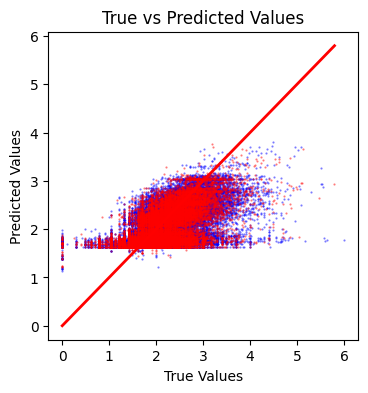

In [95]:
### Diagnostic Plots for the Best-Fit Model

plt.figure(figsize=(4, 4))
#plt.scatter(y, y_pred_all, color='green', alpha=0.5, s=0.3)
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5, s=0.3)
plt.scatter(y_test, y_pred_test, color='red', alpha=0.5, s=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

In [ ]:
len(xcol_all)

In [ ]:
n = int(np.ceil(len(xcol_all)/4))
fig, axs = plt.subplots(n, 4, figsize=(15, 15), layout='constrained')

for ax, feature in zip(axs.flat, xcol_all):
    #print(ax, feature)
    #ax.figure(figsize=(4, 4))
    X = df_preprocessed[feature]
    y = m_giving_logp1
    ax.scatter(X, y, color='blue', alpha=0.5, s=0.3)
    # ax.xlabel("%s_train" %feature)
    # ax.ylabel("y_train")
    ax.set_title('y_train vs %s' %feature)

In [ ]:
# Residuals
residuals = y_test - y_pred_test

plt.figure(figsize=(4, 4))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.savefig("%s_pred_mod_residuals_hist.jpg" %client, bbox_inches="tight")
plt.show()